In [1]:
from ipynb.fs.full.my_functions import process_data, train_models, CV, predict, metric, param_selection, best_params, errors, remove_outliers
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import shap

In [2]:
cm = 1/2.54
plt.rcParams["figure.figsize"] = (10*cm,10*cm)
plt.rcParams['lines.linewidth'] = 5*cm
plt.rcParams['lines.markersize'] = 3.5*cm
plt.rcParams['figure.dpi'] = 100
plt.rcParams['xtick.major.size'] = 3.5*cm
plt.rcParams['ytick.major.size'] = 3.5*cm
plt.rcParams['xtick.minor.size'] = 2.5*cm
plt.rcParams['ytick.minor.size'] = 2.5*cm
plt.rcParams['font.size'] = 18*cm
plt.rcParams['axes.titlesize'] = 24*cm
plt.rcParams['axes.labelsize'] = 24*cm
plt.rcParams['xtick.labelsize'] = 18*cm
plt.rcParams['ytick.labelsize'] = 18*cm
plt.rcParams['legend.fontsize'] = 18*cm
plt.rcParams['figure.titlesize'] = 24*cm
# t.t.rc('font', size=24*cm)          # controls default text sizes
# plt.rc('axes', titlesize=24*cm)     # fontsize of the axes title
# plt.rc('axes', labelsize=24*cm)    # fontsize of the x and y labels
# plt.rc('xtick', labelsize=18*cm)    # fontsize of the tick labels
# plt.rc('ytick', labelsize=18*cm)    # fontsize of the tick labels
# plt.rc('legend', fontsize=18*cm)    # legend fontsize
# plt.rc('figure', titlesize=24*cm)  # fontsize of the figure title

In [4]:
# Split data
features = ['Gen_RPM', 'Gen_Phase_Temp', 'Nac_Temp', 'Wind_Speed', 'Humidity']
target = 'Gen_Bear_Temp'

df = pd.read_pickle("modeling.pkl")

train = df.loc[:'2016'].copy()
test = df.loc['2017':].copy()

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

In [3]:
# Save df as pickle
df = process_data()
df.to_pickle("modeling.pkl")

In [7]:
df = pd.read_pickle("modeling_all_models.pkl")
# df.to_pickle("modeling_all_models.pkl")

In [ ]:
# Use to find errors in my_functions notebook
%run my_functions.ipynb

# Plotting data splits

In [ ]:
fig, axes = plt.subplots(1, len(df[[target] + features].columns), figsize=(20*cm, 10*cm))

red_circle = dict(markerfacecolor='red', marker='o', markeredgecolor='white', ms=3.5)
for i, ax in enumerate(axes.flat):
    ax.boxplot(df[[target] + features].iloc[:,i], flierprops=red_circle)
    ax.set_title(df[[target] + features].columns[i])
    ax.tick_params(axis='y')
    ax.axes.get_xaxis().set_visible(False)

plt.tight_layout()
plt.savefig(r'figs\box_plot.png', bbox_inches='tight')
plt.show()

In [ ]:
# Plot train/test split
fig, ax = plt.subplots(figsize=(15,7))
train.Gen_Bear_Temp.plot(ax=ax, label='Training Set')
test.Gen_Bear_Temp.plot(ax=ax, label='Test Set')
ax.axvline('2017', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
ax.set_ylabel('Temperature ($^\circ$C)')
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))

#plt.savefig(r'figs\train_test_split.png', bbox_inches='tight')
plt.show()

In [ ]:
# Plot train/validation/test split
train_short = df.loc[df.index < '2016-09']
cv = df.loc[(df.index >= '2016-09') & (df.index < '2017')]

fig, ax = plt.subplots(figsize=(15,7))
train_short.Gen_Bear_Temp.plot(ax=ax, label='Training')
cv.Gen_Bear_Temp.plot(ax=ax, label='Validation')
test.Gen_Bear_Temp.plot(ax=ax, label='Test')
ax.axvline('2017', color='black', ls='--')
ax.axvline('2016-09', color='black', ls='--')
ax.legend(['Training Set', 'Validation Set', 'Test Set'])
ax.set_ylabel('Temperature ($^\circ$C)')

locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(formatter)

plt.savefig(r'figs\train_val_test_split.png', bbox_inches='tight')
plt.show()

In [ ]:
# Plot cross validation folds
tss = TimeSeriesSplit(n_splits=4, test_size=6*24*30, gap=6*24)

fig, axs = plt.subplots(4, 1, figsize=(15, 10), sharex=True)

cv_df = df.loc[df.index < '2017'].copy()

fold = 0
for train_idx, val_idx in tss.split(cv_df):
    train = cv_df.iloc[train_idx]
    test = cv_df.iloc[val_idx]
    train['Gen_Bear_Temp'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['Gen_Bear_Temp'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    axs[fold].xaxis.set_major_locator(mdates.MonthLocator())

    fold += 1

plt.savefig(r'figs\folds.png', bbox_inches='tight')    
plt.show()

In [ ]:
import matplotlib.dates as dates
plt_dates = dates.date2num(df.index.to_pydatetime())

In [ ]:
fig = plt.figure(figsize=(15,7))

# The dimensions can then be added (left, bottom, width, height) for each figure
fig1 = fig.add_axes([0.1,0.1,0.8,0.8])
plt.gca().set_ylim(0,200)

# Each figure can be plotted and axes and tiles can be added
start = '2017'
fig1.plot(df.query('Gen_Bear2_Temp < 100')[start:]['Gen_Bear_Temp'], lw=1, label='Generator bearing (drive-end)')
fig1.plot(df.query('Gen_Bear2_Temp < 100')[start:]['Gen_Bear2_Temp'], lw=1, label='Generator bearing (driven end)')
plt.gca().axvspan('2017-08-20 08:10:00', '2017-08-28 21:50', color="green", alpha=0.3, label='Downtime')
fig1.set_xlabel('Date')
fig1.set_ylabel('Temperature ($^\circ$C)')

# time = '2017-08-20 08:00:00'
# plt.gca().annotate('Generator bearings damaged',
#             xy=(time, df.loc[time]['Gen_Bear2_Temp']),
#             xytext=(-130, 25), textcoords='offset points',
#             ha='center', va='bottom',
#              bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.4),
#             arrowprops=dict(arrowstyle='->', connectionstyle='arc3', 
#                             color='black', lw=2))

time = '2017-08-21 16:50:00'
plt.gca().annotate('Generator damaged',
            xy=(time, df.loc[time]['Gen_Bear_Temp']),
            xytext=(-100, -50), textcoords='offset points',
            ha='center', va='bottom',
             bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.4),
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3', 
                            color='black', lw=2))

ax = plt.gca()
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(formatter)
plt.setp(ax.get_xticklabels(), rotation=0, ha="center")
plt.legend()


fig2 = fig.add_axes([0.18,0.6,0.4,0.25])
start = '2017-08-15'
end = '2017-08'
fig2.plot(df.query('Gen_Bear2_Temp < 100')[start:end]['Gen_Bear_Temp'], lw=1, label='Generator bearing (drive-end)')
fig2.plot(df.query('Gen_Bear2_Temp < 100')[start:end]['Gen_Bear2_Temp'], lw=1, label='Generator bearing (driven end)')
plt.gca().axvspan('2017-08-20 08:10:00', '2017-08-28 21:50', color="green", alpha=0.3, label='Downtime') 
plt.gca().set_ylim(0,100)
# fig2.set_xlabel('Date')
# fig2.set_ylabel('Temperature ($^\circ$C)')

# time = '2017-08-20 08:00:00'
# plt.gca().annotate('Generator bearings damaged',
#             xy=(time, df.loc[time]['Gen_Bear2_Temp']),
#             xytext=(-120, 25), textcoords='offset points',
#             ha='center', va='bottom',
#              bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.4),
#             arrowprops=dict(arrowstyle='->', connectionstyle='arc3', 
#                             color='black', lw=2))

# time = '2017-08-21 16:50:00'
# ax.annotate('Generator damaged',
#             xy=(time, df.loc[time]['Gen_Bear_Temp']),
#             xytext=(-150, -50), textcoords='offset points',
#             ha='center', va='bottom',
#              bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.4),
#             arrowprops=dict(arrowstyle='->', connectionstyle='arc3', 
#                             color='black', lw=2))

ax = plt.gca()
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
plt.setp(ax.get_xticklabels(), rotation=0, ha="center")

plt.show()

In [ ]:
fig, ax = plt.subplots()

start = '2016-04-29'
end = '2016-04-29'

df[start:end]['Gen_Bear_Temp'].plot(style='o', ms=3.5, label='Gen bearing (drive-end)', ax=ax, x_compat=True)
df[start:end]['Gen_Bear2_Temp'].plot(style='v', ms=3.5, label='Gen bearing (driven end)', ax=ax, x_compat=True)

locator = mdates.AutoDateLocator(maxticks=7)
# locator.intervald[HOURLY] = [3]
# locator = HourLocator(3, month=5, day=29)
formatter = mdates.ConciseDateFormatter(locator)

# formatter = mdates.DateFormatter('%H')
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.set_ylabel('Temperature (\u00B0C)')
# ax.set_ylim(0,225)
ax.set_yticks([0,50,100,150,200])
plt.setp(ax.get_xticklabels(), rotation=0, ha="center")
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.legend()
plt.tight_layout()

plt.savefig('figs\gen_29_04_2016.png', bbox_inches='tight')
plt.show()

In [ ]:
fig, ax = plt.subplots(2, figsize=(10*cm,20*cm), sharey=True)

start = '2017'
df.query('Gen_Bear2_Temp < 100')[start:]['Gen_Bear_Temp'].plot(label='Gen bearing (drive-end)', ax=ax[0], title='(A)')
df.query('Gen_Bear2_Temp < 100')[start:]['Gen_Bear2_Temp'].plot(label='Gen bearing (driven end)', ax=ax[0])

ax[0].axvspan('2017-08-20 08:10:00', '2017-08-28 21:50', color="green", alpha=0.3, label='Downtime') 

time = '2017-08-20 08:00:00'
ax[0].annotate('Gen bearings damaged',
            xy=(time, df.loc[time]['Gen_Bear2_Temp']),
            xytext=(40, 30), textcoords='offset points',
            ha='center', va='bottom',
             bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.6),
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3', 
                            color='black', lw=2))

time = '2017-08-21 16:50:00'
ax[0].annotate('Generator damaged',
            xy=(time, df.loc[time]['Gen_Bear_Temp']),
            xytext=(-50, -50), textcoords='offset points',
            ha='center', va='bottom',
             bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.6),
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3', 
                            color='black', lw=2))

locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax[0].xaxis.set_major_locator(mdates.MonthLocator())
ax[0].xaxis.set_major_formatter(formatter)
# plt.setp(ax[0].get_xticklabels(), rotation=0, ha="center")

ax[0].set_ylabel('Temperature (\u00B0C)')
ax[0].set_ylim(0,110)
ax[0].legend(loc=2)
plt.setp(ax[0].get_xticklabels(), rotation=0, ha="center")

start = '2017-08-15'
end = '2017-08'
df.query('Gen_Bear2_Temp < 100')[start:end]['Gen_Bear_Temp'].plot(label='Gen bearing (drive-end)', ax=ax[1], x_compat=True, title='(B)')
df.query('Gen_Bear2_Temp < 100')[start:end]['Gen_Bear2_Temp'].plot(label='Gen bearing (driven end)', ax=ax[1], x_compat=True)

ax[1].axvspan('2017-08-20 08:10:00', '2017-08-28 21:50', color="green", alpha=0.3, label='Downtime') 

time = '2017-08-20 08:00:00'
ax[1].annotate('Gen bearings damaged',
            xy=(time, df.loc[time]['Gen_Bear2_Temp']),
            xytext=(50, 20), textcoords='offset points',
            ha='center', va='bottom',
             bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.6),
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3', 
                            color='black', lw=1))

time = '2017-08-21 16:50:00'
ax[1].annotate('Generator damaged',
            xy=(time, df.loc[time]['Gen_Bear_Temp']),
            xytext=(-15, -40), textcoords='offset points',
            ha='center', va='bottom',
             bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.6),
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3', 
                            color='black', lw=1))

locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
# formatter = mdates.DateFormatter('%H')
ax[1].xaxis.set_major_locator(mdates.DayLocator())
ax[1].xaxis.set_major_formatter(formatter)
ax[1].set_ylabel('Temperature (\u00B0C)')
plt.setp(ax[1].get_xticklabels(), rotation=0, ha="center")

# handles, labels = ax[0].get_legend_handles_labels()
# fig.legend(handles, labels, fontsize=12)
plt.tight_layout()

plt.savefig('figs\gen_failures.png', bbox_inches='tight')
plt.show()

In [ ]:
fig, ax = plt.subplots(2, figsize=(12,10), sharey=True)
plt.rcParams.update({'font.size': 16}) # must set in top

# import matplotlib
# matplotlib.rcParams.update(matplotlib.rcParamsDefault)

start = '2017'
df.query('Gen_Bear2_Temp < 100')[start:]['Gen_Bear_Temp'].plot(label='Generator bearing (drive-end)', ax=ax[0], title='(A)', fontsize=16)
df.query('Gen_Bear2_Temp < 100')[start:]['Gen_Bear2_Temp'].plot(label='Generator bearing (driven end)', ax=ax[0], fontsize=16)

ax[0].axvspan('2017-08-20 08:10:00', '2017-08-28 21:50', color="green", alpha=0.3, label='Downtime') 

time = '2017-08-20 08:00:00'
ax[0].annotate('Generator bearings damaged',
            xy=(time, df.loc[time]['Gen_Bear2_Temp']),
            xytext=(-130, 25), textcoords='offset points',
            ha='center', va='bottom',
             bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.4),
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3', 
                            color='black', lw=2), fontsize=12)

time = '2017-08-21 16:50:00'
ax[0].annotate('Generator damaged',
            xy=(time, df.loc[time]['Gen_Bear_Temp']),
            xytext=(-100, -50), textcoords='offset points',
            ha='center', va='bottom',
             bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.4),
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3', 
                            color='black', lw=2), fontsize=12)

locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax[0].xaxis.set_major_locator(mdates.MonthLocator())
ax[0].xaxis.set_major_formatter(formatter)
plt.setp(ax[0].get_xticklabels(), rotation=0, ha="center")

ax[0].set_ylabel('Temperature ($^\circ$C)', fontsize=16)
ax[0].set_ylim(0,110)
ax[0].legend(loc=1,fontsize=12)
plt.setp(ax[0].get_xticklabels(), rotation=0, ha="center", fontsize=12)
plt.setp(ax[0].get_yticklabels(), fontsize=12)

start = '2017-08-15'
end = '2017-08'
df.query('Gen_Bear2_Temp < 100')[start:end]['Gen_Bear_Temp'].plot(label='Generator bearing (drive-end)', ax=ax[1], x_compat=True, title='(B)', fontsize=16)
df.query('Gen_Bear2_Temp < 100')[start:end]['Gen_Bear2_Temp'].plot(label='Generator bearing (driven end)', ax=ax[1], x_compat=True, fontsize=16)

ax[1].axvspan('2017-08-20 08:10:00', '2017-08-28 21:50', color="green", alpha=0.3, label='Downtime') 

time = '2017-08-20 08:00:00'
ax[1].annotate('Generator bearings damaged',
            xy=(time, df.loc[time]['Gen_Bear2_Temp']),
            xytext=(-120, 25), textcoords='offset points',
            ha='center', va='bottom',
             bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.4),
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3', 
                            color='black', lw=2), fontsize=12)

time = '2017-08-21 16:50:00'
ax[1].annotate('Generator damaged',
            xy=(time, df.loc[time]['Gen_Bear_Temp']),
            xytext=(-150, -50), textcoords='offset points',
            ha='center', va='bottom',
             bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.4),
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3', 
                            color='black', lw=2), fontsize=12)

locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
# formatter = mdates.DateFormatter('%H')
ax[1].xaxis.set_major_locator(mdates.DayLocator())
ax[1].xaxis.set_major_formatter(formatter)
ax[1].set_ylabel('Temperature ($^\circ$C)', fontsize=16)
plt.setp(ax[1].get_xticklabels(), rotation=0, ha="center", fontsize=12)
plt.yticks(fontsize=12)

# handles, labels = ax[0].get_legend_handles_labels()
# fig.legend(handles, labels, fontsize=12)
plt.tight_layout()

# plt.savefig('figs\gen_failures.png', bbox_inches='tight')
plt.show()

# Training and cv

In [ ]:
# Train models
models = train_models(X_train, y_train)

In [5]:
# write
# for model in models:
#     filename = f'{str(model)[:3]}.sav'
#     pickle.dump(model, open(filename, 'wb'))
    
# read
models_short = ['Lin', 'XGB', 'Ran', 'Pip']
models = []
for model in models_short:
    filename = f'{model}.sav'
    models.append(pickle.load(open(filename, 'rb')))

In [ ]:
# Cross-validate NaN-compatible models
CV(df, models, features, target)

In [ ]:
sns.set(style="ticks")
fig, ax = plt.subplots()
corr = train[[target] + features].corr()

heatmap = sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, annot_kws={"size": 18*cm}, ax=ax)
# plt.xticks(rotation=60) #, fontsize=12)
# plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig('figs\corr_matrix.png', bbox_inches='tight')
plt.show()

In [ ]:
g = pd.plotting.scatter_matrix(df[[target]+features], marker = 'o', hist_kwds = {'bins': 10}, alpha = 0.8)
plt.show()

In [ ]:
# sns.set_context("paper", rc={"axes.labelsize":16, "axes.ticksize":32})   
# sns.set(style="ticks", font_scale = 1.5)
# fig, ax = plt.subplots(figsize=(30*cm, 30*cm))
p = sns.pairplot(train[[target] + features], diag_kind = "hist",
             diag_kws = {'alpha':1, 'bins':25}, 
             plot_kws={"s": 3.5*cm})

# plt.tight_layout()
plt.savefig('figs\pairplot.png', bbox_inches='tight')
plt.show()

In [ ]:
sns.pairplot(train[[target] + features], hue = "Gen_Bear_Temp", diag_kind = "hist", 
             diag_kws = {'alpha':0.55, 'bins':25}, palette = "coolwarm", plot_kws={"s": 3})
plt.savefig('figs\pairplot_col.png', bbox_inches='tight')
plt.show()

# Predictions

In [6]:
# Predicting and adding predictions to main dataframe
df = predict(X_test, df, models)

0.003000020980834961
0.030063152313232422
0.8273508548736572
234.9828064441681


In [ ]:
# Make custom prediction with features in following order: 
#'Gen_RPM', 'Gen_Phase_Temp', 'Nac_Temp', 'Wind_Speed', 'Amb_temp'
models[0].predict(np.array([0, 140, 70, 19, 47]).reshape(1,-1))

# Metrics

In [ ]:
from sklearn.cluster import DBSCAN
feature_1 = 'Wind_Speed'
feature_2 = 'Gen_RPM'
X = df.query('~(Prod_Pwr < 0 & Wind_Speed >= 4 & index < 2017)').loc[:'2016'][[feature_1, feature_2]].values

db = DBSCAN(eps=3, min_samples=10).fit(X)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

# Plot the clusters
plt.scatter(X[:, 0], X[:,1], c = labels) # plotting the clusters
plt.xlabel("Wind Speed (m/s)") # X-axis label
plt.ylabel("Power (kW)") # Y-axis label
plt.show() # showing the plot

In [ ]:
feature_1 = 'Wind_Speed'
feature_2 = 'Gen_RPM'

plt.scatter(test[feature_1], test[feature_2])
plt.xlabel("Wind Speed (m/s)") # X-axis label
plt.ylabel("Power (kW)") # Y-axis label
plt.show()

In [11]:
def remove_outliers(df):
    feature_1 = 'Wind_Speed'
    feature_2 = 'Prod_Pwr'
    X = df.loc[:'2016'][[feature_1, feature_2]].values
    db = DBSCAN(eps=1.4, min_samples=10).fit(X)
    labels = db.labels_
    
    return labels

In [12]:
from sklearn.cluster import DBSCAN
# train = train.query('~(Prod_Pwr < 0 & Wind_Speed >= 4 & index < 2017)')

labels = remove_outliers(train)
labels = pd.Series(labels, train.index, name='Label')
train = pd.concat([train, labels], axis=1) 
train['Label'] = train['Label'].fillna(0)
train['Label'] = train['Label'].astype('int')
# train = train.query('Label == 0')

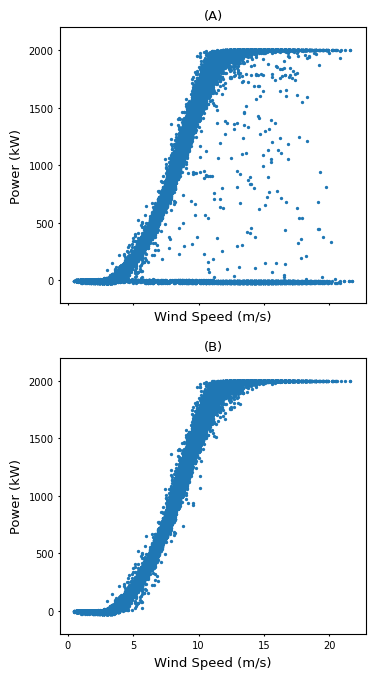

In [28]:
fig, axs = plt.subplots(2, figsize=(10*cm, 20*cm), sharey=True, sharex=True)

feature_1 = 'Wind_Speed'
feature_2 = 'Prod_Pwr'

sc = axs[0].scatter(train[feature_1], train[feature_2])
axs[0].set_xlabel("Wind Speed (m/s)") # X-axis label
axs[0].set_ylabel("Power (kW)") # Y-axis label
axs[0].set_title('(A)')
plt.ylim(-200,2200)

df1 = train.query('Label==0')
df1 = df1.query('~(Gen_Bear_Temp > 100 & index < 2017)')
df1 = df1.query('~(Prod_Pwr < 0 & Wind_Speed >= 4 & index < 2017)')
axs[1].scatter(df1[feature_1], df1[feature_2])
axs[1].set_xlabel("Wind Speed (m/s)") # X-axis label
axs[1].set_ylabel("Power (kW)") # Y-axis label
axs[1].set_title('(B)')
# axs[0].set_aspect(1.0/axs[0].get_data_ratio(), adjustable='box')

# plt.tight_layout()
plt.savefig('figs\power_curve_sc.png', bbox_inches='tight')
plt.show()

In [ ]:
# Add metrics to dataframe
metrics = metric(df, models, target)

In [ ]:
metrics

In [ ]:
# Plot metrics
ax = metrics.T.plot(kind='bar', title='Metric Scores', xlabel='Metric', ylabel='Score', width=0.8)

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005), rotation=45)

plt.xticks(rotation=0)
plt.show()

# Plotting predicted and actual values

In [ ]:
import datetime as dt

In [ ]:
# Plot real value vs predicted values
start = '2017-06-07'
end = '2017-06-23'

start = '2017-05-13'
end = '2017-05-27'
# start = '2017'
# end = '2017-01-15'

fig, ax = plt.subplots(figsize=(15,7))

SD = np.std(df['XGB'] - df['Gen_Bear_Temp'])

# ax = df[start:end].groupby(pd.PeriodIndex(df[start:end].index, freq="W"))['Gen_Bear_Temp'].mean().plot(label='Actual', x_compat=True)
# df[start:end].groupby(pd.PeriodIndex(df[start:end].index, freq="W"))['XGB'].mean().plot(label='Predicted')
ax = df[start:end]['Gen_Bear_Temp'].plot(label='Actual', x_compat=True)
df[start:end]['XGB'].plot(label='Predicted')
(df[start:end]['XGB'] + 2*SD).plot(label='Predicted + 2SD')
(df[start:end]['XGB'] - 2*SD).plot(label='Predicted - 2SD')


ax.set_ylim(0,100)
# ax.set_ylim(20,70)
ax.set_ylabel('Temperature ($^\circ$C)')

locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(mdates.DayLocator())
# ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

# ax.axvspan('2017-06-07 21:20:00', '2017-06-08 03:00:00', color="green", alpha=0.3) 
# ax.axvspan('2017-08-20 08:10', '2017-08-21 15:50', color="green", alpha=0.3) 
# ax.axvspan('2017-08-20 07:50', '2017-08-28 22:10', color="green", alpha=0.3) 
ax.axvspan('2017-05-15 15:50', '2017-05-15 21', color="green", alpha=0.3) 
# ax.axvspan('2017-06-19 20:30', '2017-06-20 01:20', color="green", alpha=0.3) 

# time = '2017-01-07 17:40:00'
# ax.annotate(time,
#             xy=(time, df.loc[time]['Gen_Bear_Temp']),
#             xytext=(50, 70), textcoords='offset points',
#             ha='center', va='bottom',
#              bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.4),
#             arrowprops=dict(arrowstyle='->', connectionstyle='arc3', 
#                             color='black', lw=2), fontsize=12)

# time = '2017-06-07 23:10:00'
# ax.annotate(time,
#             xy=(time, df.loc[time]['Gen_Bear_Temp']),
#             xytext=(-130, -50), textcoords='offset points',
#             ha='center', va='bottom',
#              bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.4),
#             arrowprops=dict(arrowstyle='->', connectionstyle='arc3', 
#                             color='black', lw=2), fontsize=12)

# time = '2017-06-07 23:10:00'
# ax.annotate(time,
#             xy=(time, df.loc[time]['Gen_Bear_Temp']),
#             xytext=(130, -10), textcoords='offset points',
#             ha='center', va='bottom',
#              bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.4),
#             arrowprops=dict(arrowstyle='->', connectionstyle='arc3', 
#                             color='black', lw=2), fontsize=12)

# time = '2017-08-27 07:20:00'
# ax.annotate(time,
#             xy=(time, df.loc[time]['XGB']),
#             xytext=(-30, 120), textcoords='offset points',
#             ha='center', va='bottom',
#              bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.4),
#             arrowprops=dict(arrowstyle='->', connectionstyle='arc3', 
#                             color='black', lw=2), fontsize=12)

# time = '2017-08-20 07:50'
# ax.annotate(time,
#             xy=(time, df.loc[time]['XGB']),
#             xytext=(-100, 70), textcoords='offset points',
#             ha='center', va='bottom',
#              bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.4),
#             arrowprops=dict(arrowstyle='->', connectionstyle='arc3', 
#                             color='black', lw=2), fontsize=12)

for label in ax.get_xticklabels(which='major'):
    label.set(rotation=0, horizontalalignment='center')

plt.legend(loc=1, framealpha=1)
plt.savefig('figs\preds_may.png', bbox_inches='tight')
plt.show()

In [ ]:
df.Gen_Bear_Temp.sort_values().tail(50)

In [ ]:
pd.set_option('display.max_rows', 500)

In [ ]:
# df.query('XGB + 2*@SD < Gen_Bear_Temp').head(500)

In [ ]:
# Calculate error and show timestamps of largest errors
df = errors(df, models, target)

In [ ]:
df['error_XGB'].sort_values(ascending=False).head(30)

In [ ]:
model = models[0]

print("Model coefficients:\n")
for i in range(X_train.shape[1]):
    print(X_train.columns[i], "=", model.coef_[i].round(5))

In [ ]:
start = '2016'
end = '2017'

df.loc[(df.index > start) & (df.index < end)].plot(
    x='Wind_Speed', y='Gen_Bear_Temp', style='o')

plt.show()

In [ ]:
start = '2017'
end = '2018'

df.loc[(df.index > start) & (df.index < end)].plot(
    x='Wind_Speed', y='Gen_Bear_Temp', style='o')

plt.show()

# Hyperparameter tuning

In [ ]:
# GridSearch to tune hyperparameters of selected model
model = models[3]
param_grid = param_selection(model)
scores = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2']

tss = TimeSeriesSplit(n_splits=4, test_size=6*24*30, gap=6*24)
search = GridSearchCV(model, param_grid, cv=tss, verbose=3, n_jobs=-1, scoring=scores, refit='r2')

grid = best_params(X_train, y_train, search)
grid

In [ ]:
grid.to_pickle("param_tuning.pkl")

In [ ]:
grid = pd.read_pickle("param_tuning.pkl")

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(12,9))
color = plt.rcParams['axes.prop_cycle'].by_key()['color'][2]

y2_ticks = [0.975, 0.98, 0.985, 0.99, 0.995, 1]
#[0.970, 0.974, 0.978, 0.982, 0.986, 0.99]

cv_results = abs(grid.loc[
    (grid['param_max_depth'] == 4) & (grid['param_n_estimators'] == 1000) # learning_rate
][[
    'param_learning_rate', 'param_max_depth', 'param_n_estimators', 'mean_test_neg_mean_absolute_error', 
    'mean_test_neg_mean_squared_error', 'mean_test_r2']])

N_est = cv_results.param_learning_rate
R2 = cv_results.mean_test_r2
RMSE = np.sqrt(cv_results.mean_test_neg_mean_squared_error)
MAE = cv_results.mean_test_neg_mean_absolute_error

lns1 = ax[0].plot(N_est, RMSE, '-s', label = 'RMSE', lw=2)
lns2 = ax[0].plot(N_est, MAE, '-o', label = 'MAE', lw=2)
ax2 = ax[0].twinx()
lns3 = ax2.plot(N_est, R2, '-d', label = 'R\u00b2', lw=2, color=color)

lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
ax[0].legend(lns, labs, loc='best')

ax[0].set_xlabel('learning_rate', fontsize=16)
ax[0].set_ylabel('Error', fontsize=16)
ax[0].set_ylim(1,2)
#ax2.set_ylim(0.965,0.99)
ax2.set_yticks(y2_ticks)
ax[0].set_xlim(0,0.11)
ax[0].set_xticks([0.01, 0.05, 0.1])
ax2.set_ylabel('R\u00b2', fontsize=16, color=color)
# ax2.spines['right'].set_color(color)
ax2.tick_params(axis='y', colors=color)

cv_results = abs(grid.loc[
    (grid['param_learning_rate'] == 0.05) & (grid['param_n_estimators'] == 1000) # max_depth
][[
    'param_learning_rate', 'param_max_depth', 'param_n_estimators', 'mean_test_neg_mean_absolute_error', 
    'mean_test_neg_mean_squared_error', 'mean_test_r2']])

N_est = cv_results.param_max_depth
R2 = cv_results.mean_test_r2
RMSE = np.sqrt(cv_results.mean_test_neg_mean_squared_error)
MAE = cv_results.mean_test_neg_mean_absolute_error

lns1 = ax[1].plot(N_est, RMSE, '-s', label = 'RMSE', lw=2)
lns2 = ax[1].plot(N_est, MAE, '-o', label = 'MAE', lw=2)
ax2 = ax[1].twinx()
lns3 = ax2.plot(N_est, R2, '-d', label = 'R\u00b2', lw=2, color=color)

lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
ax[1].legend(lns, labs, loc='best')
ax[1].set_xlabel('max_depth', fontsize=16)
ax[1].set_ylabel('Error', fontsize=16)
ax[1].set_ylim(1,2)
ax2.set_yticks(y2_ticks)
#ax2.set_ylim(0.98, 0.99)
ax[1].set_xlim(2,10)
ax[1].set_xticks([3, 4, 5, 6, 7, 8, 9])
ax2.set_ylabel('R\u00b2', fontsize=16, color=color)
# ax2.spines['right'].set_color(color)
ax2.tick_params(axis='y', colors=color)

cv_results = abs(grid.loc[
    (grid['param_max_depth'] == 4) & (grid['param_learning_rate'] == 0.05) # n_estimators
][[
    'param_learning_rate', 'param_max_depth', 'param_n_estimators', 'mean_test_neg_mean_absolute_error', 
    'mean_test_neg_mean_squared_error', 'mean_test_r2']])

N_est = cv_results.param_n_estimators
R2 = cv_results.mean_test_r2
RMSE = np.sqrt(cv_results.mean_test_neg_mean_squared_error)
MAE = cv_results.mean_test_neg_mean_absolute_error

lns1 = ax[2].plot(N_est, RMSE, '-s', label = 'RMSE', lw=2)
lns2 = ax[2].plot(N_est, MAE, '-o', label = 'MAE', lw=2)
ax2 = ax[2].twinx()
lns3 = ax2.plot(N_est, R2, '-d', label = 'R\u00b2', lw=2, color=color)

lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
ax[2].legend(lns, labs, loc='best', fontsize=12)
ax[2].set_xlabel('n_estimators', fontsize=16)
ax[2].set_ylabel('Error', fontsize=16)
ax[2].set_ylim(1,2)
ax[2].set_xlim(100,1100)
ax2.set_yticks(y2_ticks)
ax2.set_ylabel('R\u00b2', fontsize=16, color=color)
# ax2.spines['right'].set_color(color)
ax2.tick_params(axis='y', colors=color)


ax[0].title.set_text('(A)')
ax[1].title.set_text('(B)')
ax[2].title.set_text('(C)')

ax[0].set_box_aspect(1)
ax[1].set_box_aspect(1)
ax[2].set_box_aspect(1)

# for axs in ax.flat:
#     for tick in axs.xaxis.get_major_ticks():
#         tick.label.set_fontsize(12) 
#     for tick in axs.yaxis.get_major_ticks():
#         tick.label.set_fontsize(12) 
        
plt.tight_layout()
plt.savefig(r'figs\hyp_tuning.png', bbox_inches='tight')
plt.show()

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(11,9))

y2_ticks = [0.975, 0.98, 0.985, 0.99, 0.995, 1]
#[0.970, 0.974, 0.978, 0.982, 0.986, 0.99]

cv_results = abs(grid.loc[
    (grid['param_max_depth'] == 4) & (grid['param_n_estimators'] == 1000) # learning_rate
][[
    'param_learning_rate', 'param_max_depth', 'param_n_estimators', 'mean_test_neg_mean_absolute_error', 
    'mean_test_neg_mean_squared_error', 'mean_test_r2']])

N_est = cv_results.param_learning_rate
R2 = cv_results.mean_test_r2
RMSE = np.sqrt(cv_results.mean_test_neg_mean_squared_error)
MAE = cv_results.mean_test_neg_mean_absolute_error

lns1 = ax[0,0].plot(N_est, RMSE, '-s', label = 'RMSE', lw=2, color='b')
lns2 = ax[0,0].plot(N_est, MAE, '-o', label = 'MAE', lw=2, color='r')
ax2 = ax[0,0].twinx()
lns3 = ax2.plot(N_est, R2, '-d', label = 'R\u00b2', lw=2, color='g')

lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
ax[0,0].legend(lns, labs, loc='best')

ax[0,0].set_xlabel('learning_rate', fontsize=16)
ax[0,0].set_ylabel('Error', fontsize=16)
ax[0,0].set_ylim(1,2)
#ax2.set_ylim(0.965,0.99)
ax2.set_yticks(y2_ticks)
ax[0,0].set_xlim(0,0.11)
ax[0,0].set_xticks([0.01, 0.05, 0.1])
ax2.set_ylabel('R\u00b2')


cv_results = abs(grid.loc[
    (grid['param_learning_rate'] == 0.05) & (grid['param_n_estimators'] == 1000) # max_depth
][[
    'param_learning_rate', 'param_max_depth', 'param_n_estimators', 'mean_test_neg_mean_absolute_error', 
    'mean_test_neg_mean_squared_error', 'mean_test_r2']])

N_est = cv_results.param_max_depth
R2 = cv_results.mean_test_r2
RMSE = np.sqrt(cv_results.mean_test_neg_mean_squared_error)
MAE = cv_results.mean_test_neg_mean_absolute_error

lns1 = ax[0,1].plot(N_est, RMSE, '-s', label = 'RMSE', lw=2, color='b')
lns2 = ax[0,1].plot(N_est, MAE, '-o', label = 'MAE', lw=2, color='r')
ax2 = ax[0,1].twinx()
lns3 = ax2.plot(N_est, R2, '-d', label = 'R\u00b2', lw=2, color='g')

lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
ax[0,1].legend(lns, labs, loc='best')

ax[0,1].set_xlabel('max_depth', fontsize=16)
ax[0,1].set_ylabel('Error', fontsize=16)
ax[0,1].set_ylim(1,2)
ax2.set_yticks(y2_ticks)
#ax2.set_ylim(0.98, 0.99)
ax[0,1].set_xlim(2,10)
ax[0,1].set_xticks([3, 4, 5, 6, 7, 8, 9])
ax2.set_ylabel('R\u00b2')


cv_results = abs(grid.loc[
    (grid['param_max_depth'] == 4) & (grid['param_learning_rate'] == 0.05) # n_estimators
][[
    'param_learning_rate', 'param_max_depth', 'param_n_estimators', 'mean_test_neg_mean_absolute_error', 
    'mean_test_neg_mean_squared_error', 'mean_test_r2']])

N_est = cv_results.param_n_estimators
R2 = cv_results.mean_test_r2
RMSE = np.sqrt(cv_results.mean_test_neg_mean_squared_error)
MAE = cv_results.mean_test_neg_mean_absolute_error

lns1 = ax[1,0].plot(N_est, RMSE, '-s', label = 'RMSE', lw=2, color='b')
lns2 = ax[1,0].plot(N_est, MAE, '-o', label = 'MAE', lw=2, color='r')
ax2 = ax[1,0].twinx()
lns3 = ax2.plot(N_est, R2, '-d', label = 'R\u00b2', lw=2, color='g')

lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
ax[1,0].legend(lns, labs, loc='best')
ax[1,0].set_xlabel('n_estimators', fontsize=16)
ax[1,0].set_ylabel('Error', fontsize=16)
ax[1,0].set_ylim(1,2)
#ax2.set_ylim(0.97, 0.99)
ax2.set_yticks(y2_ticks)
ax[1,0].set_xlim(100,1100)
ax2.set_ylabel('R\u00b2')

ax[0,0].title.set_text('(A)')
ax[0,1].title.set_text('(B)')
ax[1,0].title.set_text('(C)')

ax[1][1].set_visible(False)
ax[0,0].set_box_aspect(1)
ax[0,1].set_box_aspect(1)
ax[1,0].set_box_aspect(1)

plt.tight_layout()
plt.savefig(r'figs\hyp_tuning.png', bbox_inches='tight')
plt.show()

# Residuals

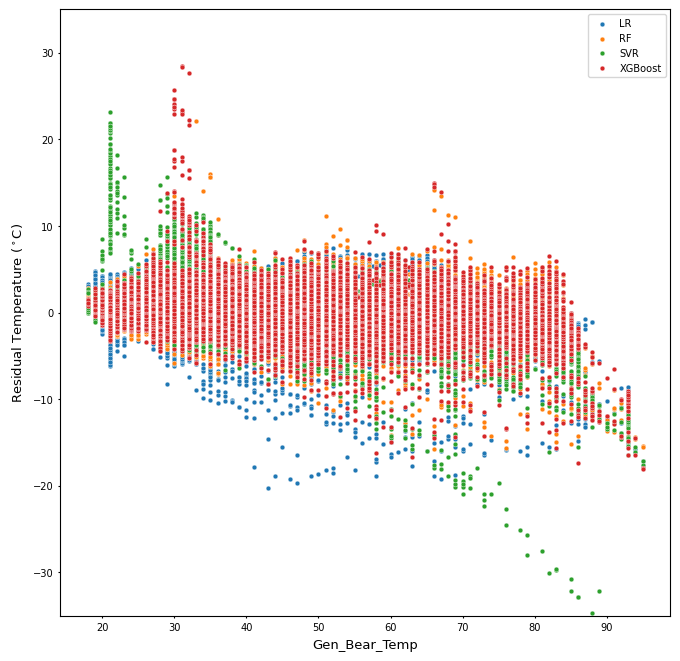

In [13]:
columns =  ['Lin', 'Ran', 'Pip', 'XGB']
labels = ['LR', 'RF', 'SVR', 'XGBoost']
symbols = ['s', 'o', 'd', '^']

# resid = df.query('index >= 2017')[col] - df.query('index >= 2017')['Gen_Bear_Temp']


fig, ax = plt.subplots(figsize=(20*cm,20*cm))

for idx, col in enumerate(columns):
#     ax = sns.residplot(x=y_test, y=df.query('index >= 2017')[col], scatter_kws={'alpha':1, 'marker':symbols[idx], 's':60}, label=labels[idx])
    resid = df.query('index >= 2017')[col] - df.query('index >= 2017')['Gen_Bear_Temp']
    ax = sns.scatterplot(x=y_test, y=resid, label=labels[idx], s=30.5*cm)

ax.set_ylim(-35,35)
plt.ylabel('Residual Temperature ($^\circ$C)')
plt.legend()
# plt.savefig(r'figs\residuals_all.png', bbox_inches='tight')
plt.show()

In [ ]:
fig, ax = plt.subplots(4,1, figsize=(15,20), sharey=True)
columns =  ['Lin', 'Ran', 'Pip', 'XGB']
labels = ['LR', 'RF', 'SVR', 'XGBoost']

for idx, col in enumerate(columns):
    sns.residplot(x=y_test, y=df.query('index >= 2017')[col], scatter_kws={'alpha':0.6}, ax=ax[idx], label=labels[idx])
    ax[idx].legend()
    ax[idx].set_ylim(-30,30)
    ax[idx].set_ylabel('Residuals')

# plt.savefig(r'figs\residuals_ind.png', bbox_inches='tight')
plt.show()

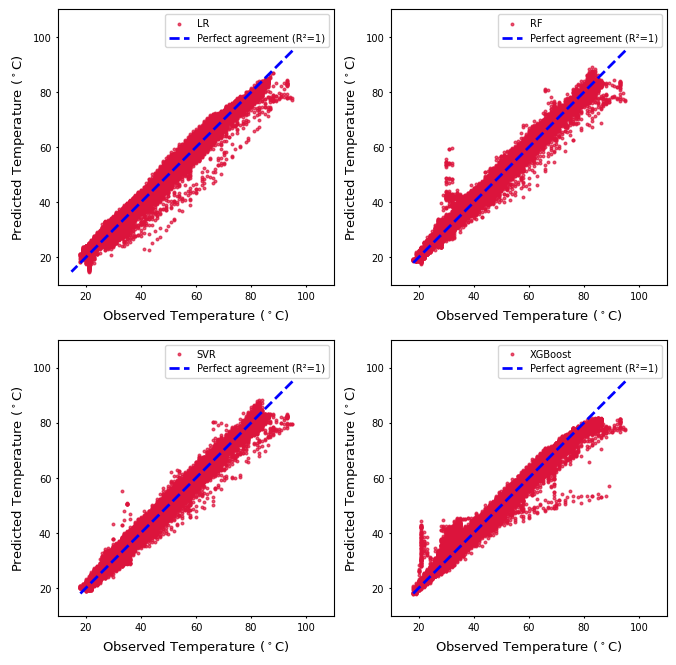

In [24]:
fig, axs = plt.subplots(2, 2, figsize=(20*cm,20*cm))
true_value = y_test
labels = ['LR', 'RF', 'SVR', 'XGBoost']
for idx, model in enumerate(models):
    model = str(model)[:3]
    plt.subplot(2, 2, idx+1)
    predicted_value = df[model].loc[df[model].notna()]
    lo = plt.scatter(true_value, predicted_value, c='crimson', alpha=0.7, s=3.5, label=labels[idx])

    p1 = max(max(predicted_value), max(true_value))
    p2 = min(min(predicted_value), min(true_value))
    plt.plot([p1, p2], [p1, p2], 'b--', label='Perfect agreement (R\u00b2=1)')
    plt.xlabel('Observed Temperature ($^\circ$C)')
    plt.ylabel('Predicted Temperature ($^\circ$C)')
    plt.gca().set_xlim(10,110)
    plt.gca().set_ylim(10,110)
    plt.gca().set_aspect('equal')
    plt.legend()

plt.savefig(r'figs\perf_agr.png', bbox_inches='tight')
plt.show()

In [ ]:
plt.figure(figsize=(8,8))
true_value = y_test
predicted_value = df['XGB'].loc[df['XGB'].notna()]
plt.scatter(true_value, predicted_value, c='crimson', alpha=0.6, lw=0.001)

p1 = max(max(predicted_value), max(true_value))
p2 = min(min(predicted_value), min(true_value))
plt.plot([p1, p2], [p1, p2], 'b--')
plt.xlabel('Observed Bearing Temperature ($^\circ$C)')
plt.ylabel('Predicted Bearing Temperature ($^\circ$C)')
plt.axis('equal')
plt.show()

In [ ]:
import graphviz
import pylab

names = [
         "Wind speed", "Generator RPM", "Humidity",
         "Nacelle temperature", "Generator phase temperature",
]
g = graphviz.Digraph(format='png')
for name in names:
    g.node(name, fontsize="10")
    
g.node("Generator bearing temperature", style="filled", fontsize="10")
g.edge("Wind speed", "Generator RPM")
g.edge("Generator RPM", "Generator phase temperature")
g.edge("Generator RPM", "Generator bearing temperature")
g.edge("Generator phase temperature", "Generator bearing temperature")
g.edge("Nacelle temperature", "Generator bearing temperature")
g.edge("Humidity", "Generator bearing temperature")

g.view()

filename = g.render(filename='img/g')

# pylab.savefig('features.png')

In [ ]:
feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feat_importances = feat_importances.sort_values()

plt.barh(feat_importances.index, feat_importances.values)
plt.xlabel('Share of total feature importance')
plt.show()

# SHAP
### Global Explanation

In [ ]:
import xgboost as xgb
XGB = xgb.XGBRegressor(
    booster='gbtree',    
    n_estimators=100,
    objective='reg:squarederror',
    max_depth=9,
    learning_rate=0.1,
    colsample_bytree =0.6,
    colsample_bylevel=0.6,
    verbosity=0,
    n_jobs=-1,
    random_state=42
)
XGB.fit(X_train, y_train)
model = XGB

In [ ]:
shap.__version__

In [ ]:
pd.__version__

In [ ]:
np.version.version

In [ ]:
model = models[0]
sample = X_test
#sample = shap.sample(X_test, 5000, random_state=42)
explainer = shap.TreeExplainer(model)
shap_values = explainer(sample)

In [ ]:
shap.summary_plot(shap_values, sample, alpha=0.05, plot_size=None, show=False)
axs[1].set_xlabel("SHAP value")
axs[1].set_title('(B)')
# plt.gcf().set_size_inches(13,5)
# plt.savefig(r'figs\shap_bee_bar.png', bbox_inches='tight')
plt.tight_layout()
plt.show()

In [ ]:
# summary plots
fig, axs = plt.subplots(1,2, figsize=(15,7))

plt.subplot(1,2,1)
shap.summary_plot(shap_values, sample, plot_type='bar', show=False)
# shap.plots.bar(shap_values, 
#                #clustering=clust, 
#                #clustering_cutoff=0, 
#                show=False)
axs[0].set_xlabel("Mean absolute SHAP value")
axs[0].set_title('(A)')

plt.subplot(1,2,2)
shap.summary_plot(shap_values, sample, alpha=0.05, show=False)
# plt.gcf().axes[-1].set_aspect(100)
# plt.gcf().axes[-1].set_box_aspect(100)
axs[1].set_xlabel("SHAP value")
axs[1].set_title('(B)')
plt.gcf().set_size_inches(13,5)
plt.tight_layout()
plt.savefig(r'figs\shap_bee_bar.png', bbox_inches='tight')
plt.show()

In [ ]:
# bar summary plot
#clust = shap.utils.hclust(X_test, y_test, linkage="single", random_state=42)
shap.plots.bar(shap_values, 
               #clustering=clust, 
               #clustering_cutoff=0, 
               show=False)
plt.xlabel('Mean absolute SHAP value')
# plt.savefig(r'figs\shap_summary_bar.png', bbox_inches='tight')
plt.show()

In [ ]:
# scatter plot with colored interactions
fig, ax = plt.subplots(3,2, sharey=True)
axes = ax.ravel()
titles = ['(A)', '(B)', '(C)', '(D)', '(E)']

for idx, col in enumerate(X_test.columns):
    shap.dependence_plot(col, shap_values.values, X_test, alpha=0.5, ax=axes[idx], show=False)    
    axes[idx].set_title(titles[idx])

ax[2][1].set_visible(False)
plt.gcf().set_size_inches(13,10)
plt.tight_layout()
# plt.savefig(r'figs\shap_w_ix.png', bbox_inches='tight')
plt.show()

### Interactions

In [ ]:
X_interaction = X_test#shap.sample(X_test, 5000, random_state=42)
shap_interaction_values = shap.TreeExplainer(model).shap_interaction_values(X_interaction)

In [ ]:
shap.summary_plot(shap_interaction_values, X_interaction, show=False)
plt.gcf().set_size_inches(25,8)
plt.show()

In [ ]:
# main effect plot
fig, ax = plt.subplots(3,2, sharey=True)
axes = ax.ravel()
titles = ['(A)', '(B)', '(C)', '(D)', '(E)']

for idx, col in enumerate(X_test.columns):
    shap.dependence_plot((col, col), shap_interaction_values, X_interaction, alpha=0.5, ax=axes[idx], show=False) 
    axes[idx].set_title(titles[idx])

ax[2][1].set_visible(False)
plt.gcf().set_size_inches(13,10)
plt.tight_layout()
plt.savefig(r'figs\shap_main_effect.png', bbox_inches='tight')
plt.show()

In [ ]:
# interaction between two and two features
feature = 'Gen_RPM'
cols = X_test.columns.drop(feature)
titles = ['(A)', '(B)', '(C)', '(D)', '(E)']

fig, ax = plt.subplots(2,2, sharey=True)
axes = ax.ravel()

for idx, col in enumerate(cols):
    shap.dependence_plot((feature, col), shap_interaction_values, X_interaction, ax=axes[idx], show=False)
    axes[idx].set_title(titles[idx])

plt.gcf().set_size_inches(13,8)
plt.tight_layout()
plt.show()

### Local explanation

In [ ]:
sample = X_test
model = models[0]
explainer = shap.TreeExplainer(model)
shap_values = explainer(sample)

In [ ]:
y_test[970]
y_test[22724]
y_test[34083]

In [ ]:
X_test.iloc[970]
X_test.iloc[22724]
X_test.iloc[34083]

In [ ]:
explainerr = shap.Explainer(model)
shap_valuess = explainer.shap_values(X_test)

In [ ]:
shap.initjs()
shap.force_plot(explainerr.expected_value, shap_valuess[34083,:], features=X_test.columns)

In [ ]:
fig, ax = plt.subplots(figsize=(13,5))
shap.plots.waterfall(shap_values[22724], show=False)

plt.savefig(r'figs\waterfall_jun.png', bbox_inches='tight')
plt.show()

In [ ]:
expected_value = explainer.expected_value
sv = explainer(shap.sample(X_test, 100))

fig, ax = plt.subplots(figsize=(13,5))

#plt.subplot(1,2,1)
shap.plots.decision(expected_value, sv.values, features=X_test.columns, alpha=0.4, show=False)
# plt.savefig(r'figs\decisions_plot.png', bbox_inches='tight')
plt.show()

# ICE

In [ ]:
from pycebox.ice import ice, ice_plot

In [ ]:
features = X_test.columns
col_by = features
model = models[0]
sample = X_test

sample_short = shap.sample(sample, 50, random_state=42)

fig, axs = plt.subplots(5, 2, sharey='col', figsize=(12,25))


for idx, feature in enumerate(features):
    ice_df = ice(sample_short, feature, model.predict, num_grid_points=None)

    ice_plot(ice_df, linewidth=.5, #plot_points=True,
             color_by=col_by[idx-1], plot_pdp=True,
             pdp_kwargs={'c': 'blue', 'linewidth': 5}, 
             frac_to_plot=1, ax=axs[idx,0])

    axs[idx,0].set_xlabel(feature)
    axs[idx,0].set_ylabel('Gen_Bear_Temp')
#    axs[idx,0].set_ylim(18, 95)

    ice_plot(ice_df, linewidth=.5,
             color_by=col_by[idx-1], plot_pdp=True, #plot_points=True,
             pdp_kwargs={'c': 'blue', 'linewidth': 5},
             frac_to_plot=1, ax=axs[idx,1], 
             centered=True, cmap='coolwarm')
#     if feature == 'Nac_Temp':
#         axs[idx,1].set_ylim(0, 20)
    axs[idx,1].set_xlabel(feature)
    axs[idx,1].set_ylabel('Change in Gen_Bear_Temp')
    
#fig.suptitle('ICE Curves', fontsize=20, fontweight='bold')

#ice_ax_centered.set_title('ICE Curves');
# plt.savefig('Ice_curves.jpg', bbox_inches='tight')
plt.show()

# ALE

In [ ]:
from PyALE import ale
## two 1D plots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
ale_res_1 = ale(
    X=X_test[features],
    model=models[0],
    feature=["Gen_Phase_Temp"],
    feature_type="continuous",
    grid_size=20,
    include_CI=True,
    C=0.99,
    plot=True,
    fig=fig,
    ax=ax1,
)
ale_res_2 = ale(
    X=X_test[features],
    model=models[0],
    feature=["Nac_Temp"],
    feature_type="continuous",
    grid_size=20,
    include_CI=True,
    C=0.95,
    plot=True,
    fig=fig,
    ax=ax2,
)
# change x labels
ax1.set_xlabel("Temperature")
ax2.set_xlabel("RPM")
plt.show()

In [ ]:
# Plot two features and show their combiined effect on prediction
ale_eff = ale(X=X_test, model=models[0], feature=["Gen_Phase_Temp", "Gen_RPM"])

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df.Wind_Speed, lags=23, missing='drop', title='Wind Speed Autocorrelation')

from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df.Wind_Speed, lags=23, title='Wind Speed Partial Autocorrelation')

## dtreeviz

### Some lines are commented out due to them requiring a lot of CPU

In [ ]:
import dtreeviz
import graphviz

model = models[0]
viz_rmodel = dtreeviz.model(model,
                           X_train, y_train,
                           feature_names=features,
                           target_name=target,
                           tree_index=1                        
                          )

# viz_rmodel.view(fancy=False)

In [ ]:
x = X_train.iloc[900]
x

In [ ]:
viz_rmodel.view(show_just_path=True, x = x)

In [ ]:
from sklearn.tree import DecisionTreeRegressor 
from sklearn import tree

clf = tree.DecisionTreeRegressor(random_state=0)

clf = clf.fit(X_train[:15], y_train[:15])
tree.plot_tree(clf, feature_names=features, class_names=target, filled=True, impurity=False, rounded=True, precision=1)
plt.show()

In [ ]:
# viz_rmodel.view(x = x)

In [ ]:
print(viz_rmodel.explain_prediction_path(x))

In [ ]:
viz_rmodel.leaf_sizes()

In [ ]:
viz_rmodel.rtree_leaf_distributions()

In [ ]:
viz_rmodel.node_stats(node_id=4)

# Lime

In [ ]:
# 22724 34083

In [ ]:
import lime
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.dropna().values, feature_names=X_train.columns.values.tolist(),
                                                  class_names=[target], verbose=True, mode='regression')

In [ ]:
j = 34083
exp = explainer.explain_instance(X_test.values[j], model.predict, num_features=len(features))

In [ ]:
exp.show_in_notebook(show_table=True)

In [ ]:
exp.as_list()

In [ ]:
j = 22724
exp = explainer.explain_instance(X_test.values[j], model.predict, num_features=len(features))

In [ ]:
exp.show_in_notebook(show_table=True)

In [ ]:
exp.as_list()

In [ ]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
predictions = model.predict(X_test)

dt = DecisionTreeRegressor(random_state = 100, max_depth=3)
dt.fit(X_test, predictions)

fig, ax = plt.subplots(figsize=(20, 10))
plot_tree(dt, feature_names=list(X_test.columns), precision=3, 
           filled=True, fontsize=12, impurity=True)
plt.show()

In [ ]:
dt.score(X_test, predictions)

In [ ]:
fig, ax = plt.subplots(figsize=(25, 10))
features = ['Gen_RPM', 'Gen_Phase_Temp', ('Gen_RPM', 'Gen_Phase_Temp')]
PartialDependenceDisplay.from_estimator(LGB, X_train[:100], features, ax=ax)
fig.suptitle('Partial Dependence Plots')
fig.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(3, 2, figsize=(25, 15))
PartialDependenceDisplay.from_estimator(model, X_train[:100], features,
    kind='both', ax=ax, n_cols=1
                                       )
plt.show()

In [ ]:
var = 'Gen_RPM'
values = X_train[var].sort_values().unique()

In [ ]:
n_cols = 2
n_rows = int(len(X_train.columns)/n_cols)
fig, ax = plt.subplots(n_rows, n_cols, figsize=(10, 12))
PartialDependenceDisplay.from_estimator(XGB, X_train[:100], X_train.columns, ax=ax, n_cols=n_cols)
fig.suptitle('Partial Dependence Plots')
fig.tight_layout()
plt.show()

# Explainerdashboard

In [ ]:
from explainerdashboard import RegressionExplainer, ExplainerDashboard

In [ ]:
model = model
explainer = RegressionExplainer(model, X_test[:1000], y_test[:1000],
                                target='Gen_Bear_Temp',
                                precision='float32')

db = ExplainerDashboard(explainer,title='WT Bearing Temperature Prediction', mode='external', )

In [ ]:
db.run()

In [ ]:
ExplainerDashboard.terminate(8050)

In [ ]:
#db.to_yaml("dashboard.yaml", explainerfile="explainer.joblib", dump_explainer=True)
db = ExplainerDashboard.from_config("dashboard.yaml")
db.run()